# **Semana 13: M√©tricas Avanzadas de Evaluaci√≥n**

## Ciencia de Datos en el Deporte - An√°lisis Avanzado

### üöÄ **Bloque 3: An√°lisis Avanzado y Modelado**

---

**Objetivos de Aprendizaje:**
- ‚úÖ Dominar ROC-AUC para evaluar modelos de clasificaci√≥n
- ‚úÖ Implementar curvas Precision-Recall
- ‚úÖ Entender m√©tricas espec√≠ficas por clase
- ‚úÖ Interpretar resultados en contexto deportivo
- ‚úÖ Seleccionar m√©tricas apropiadas seg√∫n el problema

**Herramientas:**
- üêç Python
- üìä Scikit-learn (m√©tricas avanzadas)
- üìà Matplotlib/Seaborn (visualizaci√≥n de m√©tricas)
- üéØ ROC curves, Precision-Recall curves
- üìã Classification reports detallados

---

## 1. Repaso: M√°s All√° de la Precisi√≥n Simple

### 1.1 Lo que Sabemos Hasta Ahora

En las semanas anteriores hemos usado principalmente **precisi√≥n (accuracy)** para evaluar nuestros modelos:

‚úÖ **Semana 11**: Regresi√≥n Log√≠stica con accuracy b√°sico  
‚úÖ **Semana 12**: Random Forest, SVM y Ensemble con accuracy  
‚úÖ **Matrices de confusi√≥n**: Visualizaci√≥n de aciertos y errores  

### 1.2 ¬øPor qu√© Necesitamos M√©tricas M√°s Avanzadas?

La **precisi√≥n simple** tiene limitaciones importantes:

#### **Problema 1: Clases Desbalanceadas**
Imagina predecir lesiones graves en f√∫tbol:
- üü¢ **95% de jugadores**: Sin lesi√≥n grave
- üî¥ **5% de jugadores**: Con lesi√≥n grave

Un modelo que prediga "nunca hay lesi√≥n" tendr√≠a **95% de precisi√≥n**, pero ser√≠a **in√∫til** para detectar lesiones reales.

#### **Problema 2: Diferentes Tipos de Error**
En deportes, no todos los errores son iguales:
- ‚ùå **Falso Positivo**: Predecir victoria cuando hay derrota (molesto)
- ‚ùå **Falso Negativo**: No predecir una lesi√≥n grave (peligroso)

#### **Problema 3: Probabilidades vs Decisiones**
- ¬øUn modelo que dice "70% victoria" es mejor que uno que dice "51% victoria"?
- ¬øC√≥mo comparamos la **confianza** de diferentes modelos?

### 1.3 M√©tricas que Exploraremos Hoy

1. **ROC-AUC** üìà: ¬øQu√© tan bien separa nuestro modelo las clases?
2. **Precision-Recall** üéØ: Balance entre encontrar casos y evitar falsas alarmas
3. **M√©tricas por clase** üìä: Rendimiento espec√≠fico para cada resultado
4. **Interpretaci√≥n pr√°ctica** ‚öΩ: ¬øQu√© significan en el contexto deportivo?

## 2. Preparaci√≥n del Entorno

### 2.1 Cargar Librer√≠as y Datos

Empezaremos importando las herramientas necesarias para m√©tricas avanzadas:

In [1]:
# Librer√≠as b√°sicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Librer√≠as de machine learning b√°sicas
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.pipeline import Pipeline

# NUEVAS: Librer√≠as de m√©tricas avanzadas
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, roc_auc_score,  # ROC y AUC
    precision_recall_curve, average_precision_score,  # Precision-Recall
    precision_score, recall_score, f1_score,  # M√©tricas individuales
    multilabel_confusion_matrix  # Para an√°lisis por clase
)

# Configuraci√≥n de gr√°ficos
sns.set_theme(style="whitegrid", palette="Set2")
plt.rcParams['figure.figsize'] = (12, 8)

print("‚úÖ Librer√≠as de m√©tricas avanzadas cargadas:")
print("üìà ROC-AUC: Receiver Operating Characteristic")
print("üéØ Precision-Recall: Balance precisi√≥n vs cobertura")
print("üìä F1-Score: Media arm√≥nica de precisi√≥n y recall")
print("üîç M√©tricas por clase: An√°lisis detallado por categor√≠a")
print("\nüöÄ ¬°Listos para evaluaci√≥n avanzada!")

‚úÖ Librer√≠as de m√©tricas avanzadas cargadas:
üìà ROC-AUC: Receiver Operating Characteristic
üéØ Precision-Recall: Balance precisi√≥n vs cobertura
üìä F1-Score: Media arm√≥nica de precisi√≥n y recall
üîç M√©tricas por clase: An√°lisis detallado por categor√≠a

üöÄ ¬°Listos para evaluaci√≥n avanzada!


### 2.2 Recrear Datos de la Semana Anterior

Vamos a recrear nuestro dataset de partidos para tener modelos entrenados:

In [2]:
# Recrear dataset de partidos (misma l√≥gica de la semana 12)
np.random.seed(42)
n_partidos = 1000

# Equipos con diferentes niveles
equipos_top = ['Real Madrid', 'Barcelona', 'Atletico']
equipos_mid = ['Valencia', 'Sevilla', 'Villarreal', 'Betis']
equipos_low = ['Athletic', 'Sociedad', 'Getafe', 'Levante', 'Osasuna']
todos_equipos = equipos_top + equipos_mid + equipos_low

def calidad_equipo(equipo):
    if equipo in equipos_top:
        return 3
    elif equipo in equipos_mid:
        return 2
    else:
        return 1

# Generar datos
datos_partidos = {
    'equipo_local': np.random.choice(todos_equipos, n_partidos),
    'equipo_visitante': np.random.choice(todos_equipos, n_partidos),
    'goles_local_ultimos_5': np.random.randint(0, 15, n_partidos),
    'goles_visitante_ultimos_5': np.random.randint(0, 15, n_partidos),
    'victorias_local_ultimos_5': np.random.randint(0, 6, n_partidos),
    'victorias_visitante_ultimos_5': np.random.randint(0, 6, n_partidos),
    'posicion_liga_local': np.random.randint(1, 21, n_partidos),
    'posicion_liga_visitante': np.random.randint(1, 21, n_partidos),
    'es_derbi': np.random.choice([0, 1], n_partidos, p=[0.85, 0.15]),
    'diferencia_valor_mercado': np.random.normal(0, 20, n_partidos),
    'lesionados_local': np.random.randint(0, 5, n_partidos),
    'lesionados_visitante': np.random.randint(0, 5, n_partidos),
    'dias_descanso_local': np.random.randint(2, 8, n_partidos),
    'dias_descanso_visitante': np.random.randint(2, 8, n_partidos)
}

df_partidos = pd.DataFrame(datos_partidos)
df_partidos = df_partidos[df_partidos['equipo_local'] != df_partidos['equipo_visitante']]

# A√±adir calidad de equipos
df_partidos['calidad_local'] = df_partidos['equipo_local'].apply(calidad_equipo)
df_partidos['calidad_visitante'] = df_partidos['equipo_visitante'].apply(calidad_equipo)

# Simular resultados (misma funci√≥n de la semana 12)
def simular_resultado_avanzado(row):
    fortaleza_local = (
        row['goles_local_ultimos_5'] * 0.2 +
        row['victorias_local_ultimos_5'] * 0.3 +
        (21 - row['posicion_liga_local']) * 0.2 +
        row['calidad_local'] * 3 + 3
    )
    
    fortaleza_visitante = (
        row['goles_visitante_ultimos_5'] * 0.2 +
        row['victorias_visitante_ultimos_5'] * 0.3 +
        (21 - row['posicion_liga_visitante']) * 0.2 +
        row['calidad_visitante'] * 3
    )
    
    fortaleza_local += row['diferencia_valor_mercado'] * 0.1
    fortaleza_local -= row['lesionados_local'] * 0.5
    fortaleza_local += (row['dias_descanso_local'] - 4) * 0.3
    
    fortaleza_visitante -= row['diferencia_valor_mercado'] * 0.1
    fortaleza_visitante -= row['lesionados_visitante'] * 0.5
    fortaleza_visitante += (row['dias_descanso_visitante'] - 4) * 0.3
    
    if row['es_derbi'] == 1:
        factor_aleatorio = np.random.normal(0, 3)
    else:
        factor_aleatorio = np.random.normal(0, 2)
    
    diferencia = fortaleza_local - fortaleza_visitante + factor_aleatorio
    
    if diferencia > 2.0:
        return 'Victoria_Local'
    elif diferencia < -2.0:
        return 'Victoria_Visitante'
    else:
        return 'Empate'

df_partidos['resultado'] = df_partidos.apply(simular_resultado_avanzado, axis=1)

print(f"üìä Dataset recreado: {len(df_partidos)} partidos")
print("üìà Distribuci√≥n de resultados:")
print(df_partidos['resultado'].value_counts())
print("\n‚úÖ Datos listos para an√°lisis de m√©tricas avanzadas")

üìä Dataset recreado: 926 partidos
üìà Distribuci√≥n de resultados:
resultado
Victoria_Local        510
Empate                215
Victoria_Visitante    201
Name: count, dtype: int64

‚úÖ Datos listos para an√°lisis de m√©tricas avanzadas


### 2.3 Entrenar Modelos para Evaluaci√≥n

Vamos a entrenar r√°pidamente algunos modelos que usaremos para demostrar las m√©tricas:

In [3]:
# Preparar datos
features = [
    'goles_local_ultimos_5', 'goles_visitante_ultimos_5',
    'victorias_local_ultimos_5', 'victorias_visitante_ultimos_5',
    'posicion_liga_local', 'posicion_liga_visitante',
    'calidad_local', 'calidad_visitante',
    'diferencia_valor_mercado', 'lesionados_local', 'lesionados_visitante',
    'dias_descanso_local', 'dias_descanso_visitante', 'es_derbi'
]

X = df_partidos[features]
y = df_partidos['resultado']

# Divisi√≥n entrenamiento/prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Entrenar modelos r√°pidamente
print("üöÄ Entrenando modelos para demostraci√≥n...")

# 1. Regresi√≥n Log√≠stica
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=42, max_iter=1000))
])
lr_pipeline.fit(X_train, y_train)

# 2. Random Forest
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=8)
rf_model.fit(X_train, y_train)

# 3. SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))
])
svm_pipeline.fit(X_train, y_train)

# Hacer predicciones
lr_pred = lr_pipeline.predict(X_test)
lr_proba = lr_pipeline.predict_proba(X_test)

rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)

svm_pred = svm_pipeline.predict(X_test)
svm_proba = svm_pipeline.predict_proba(X_test)

print("‚úÖ Modelos entrenados:")
print(f"üìä Regresi√≥n Log√≠stica - Accuracy: {accuracy_score(y_test, lr_pred):.3f}")
print(f"üå≤ Random Forest - Accuracy: {accuracy_score(y_test, rf_pred):.3f}")
print(f"‚ö° SVM - Accuracy: {accuracy_score(y_test, svm_pred):.3f}")

print("\nüéØ ¬°Listos para explorar m√©tricas avanzadas!")

üöÄ Entrenando modelos para demostraci√≥n...
‚úÖ Modelos entrenados:
üìä Regresi√≥n Log√≠stica - Accuracy: 0.823
üå≤ Random Forest - Accuracy: 0.704
‚ö° SVM - Accuracy: 0.806

üéØ ¬°Listos para explorar m√©tricas avanzadas!


## 3. ROC-AUC: ¬øQu√© Tan Bien Separa las Clases?

### 3.1 ¬øQu√© es ROC-AUC?

**ROC-AUC** significa **Receiver Operating Characteristic - Area Under Curve**. Suena complicado, pero el concepto es simple:

#### **Analog√≠a del Portero de F√∫tbol:**
Imagina que tienes que evaluar porteros. Para cada disparo, el portero debe decidir:
- ü•Ö **"Voy a atajar"** (predicci√≥n positiva)
- ü§∑ **"No voy a atajar"** (predicci√≥n negativa)

**ROC** mide el balance entre:
- ‚úÖ **Sensibilidad (Recall)**: % de goles que S√ç ataja cuando debe atajar
- ‚ö†Ô∏è **1 - Especificidad**: % de veces que se lanza cuando NO debe (falsa alarma)

#### **¬øQu√© Significa AUC?**
- **AUC = 1.0**: Portero perfecto (separa perfectamente goles atajables de no-atajables)
- **AUC = 0.5**: Portero aleatorio (como lanzar una moneda)
- **AUC = 0.0**: Portero que siempre se equivoca (¬°invertir√≠a sus decisiones!)

### 3.2 ROC-AUC en Clasificaci√≥n Multiclase

Nuestro problema tiene **3 clases** (Victoria_Local, Empate, Victoria_Visitante), as√≠ que necesitamos adaptar ROC-AUC:

#### **Estrategias para Multiclase:**
1. **One-vs-Rest**: Cada clase contra todas las dem√°s
2. **One-vs-One**: Cada par de clases por separado
3. **Macro-average**: Promedio simple de todas las clases
4. **Weighted-average**: Promedio ponderado por frecuencia

### 3.3 Implementaci√≥n de ROC-AUC

In [4]:
# Calcular ROC-AUC para cada modelo
print("üìà AN√ÅLISIS ROC-AUC - COMPARACI√ìN DE MODELOS")
print("=" * 50)

# Para problemas multiclase, usamos diferentes estrategias
modelos_data = {
    'Regresi√≥n Log√≠stica': {'proba': lr_proba, 'pred': lr_pred},
    'Random Forest': {'proba': rf_proba, 'pred': rf_pred},
    'SVM': {'proba': svm_proba, 'pred': svm_pred}
}

resultados_roc = {}

for nombre_modelo, data in modelos_data.items():
    # Calcular ROC-AUC con diferentes estrategias
    try:
        # Macro-average: promedio simple de todas las clases
        auc_macro = roc_auc_score(y_test, data['proba'], multi_class='ovr', average='macro')
        
        # Weighted-average: promedio ponderado por frecuencia de clase
        auc_weighted = roc_auc_score(y_test, data['proba'], multi_class='ovr', average='weighted')
        
        resultados_roc[nombre_modelo] = {
            'macro': auc_macro,
            'weighted': auc_weighted,
            'accuracy': accuracy_score(y_test, data['pred'])
        }
        
        print(f"\nü§ñ {nombre_modelo}:")
        print(f"   ROC-AUC (macro):    {auc_macro:.3f}")
        print(f"   ROC-AUC (weighted): {auc_weighted:.3f}")
        print(f"   Accuracy:           {accuracy_score(y_test, data['pred']):.3f}")
        
    except Exception as e:
        print(f"‚ùå Error calculando ROC-AUC para {nombre_modelo}: {e}")

print("\n" + "=" * 50)
print("üí° INTERPRETACI√ìN:")
print("‚Ä¢ ROC-AUC = 1.0: Modelo perfecto")
print("‚Ä¢ ROC-AUC = 0.5: Modelo aleatorio")
print("‚Ä¢ ROC-AUC > 0.8: Modelo muy bueno")
print("‚Ä¢ ROC-AUC > 0.7: Modelo bueno")
print("‚Ä¢ ROC-AUC < 0.6: Modelo malo")

üìà AN√ÅLISIS ROC-AUC - COMPARACI√ìN DE MODELOS

ü§ñ Regresi√≥n Log√≠stica:
   ROC-AUC (macro):    0.935
   ROC-AUC (weighted): 0.945
   Accuracy:           0.823

ü§ñ Random Forest:
   ROC-AUC (macro):    0.859
   ROC-AUC (weighted): 0.880
   Accuracy:           0.704

ü§ñ SVM:
   ROC-AUC (macro):    0.910
   ROC-AUC (weighted): 0.925
   Accuracy:           0.806

üí° INTERPRETACI√ìN:
‚Ä¢ ROC-AUC = 1.0: Modelo perfecto
‚Ä¢ ROC-AUC = 0.5: Modelo aleatorio
‚Ä¢ ROC-AUC > 0.8: Modelo muy bueno
‚Ä¢ ROC-AUC > 0.7: Modelo bueno
‚Ä¢ ROC-AUC < 0.6: Modelo malo


### 3.4 Visualizaci√≥n de Curvas ROC

Ahora vamos a visualizar las curvas ROC para entender mejor c√≥mo se comporta cada modelo:

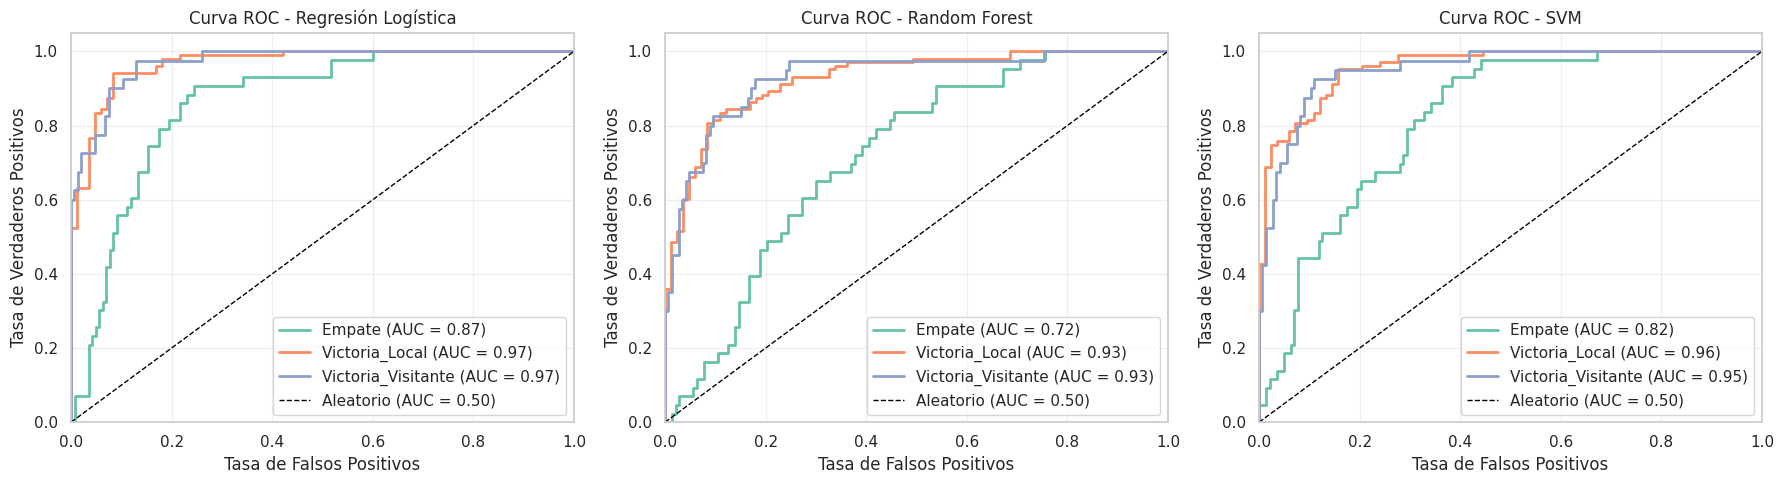

üìä RESUMEN COMPARATIVO ROC-AUC:
Regresi√≥n Log√≠stica: AUC=0.935 | ACC=0.823
Random Forest     : AUC=0.859 | ACC=0.704
SVM               : AUC=0.910 | ACC=0.806

üîç AN√ÅLISIS:
üèÜ Mejor separaci√≥n de clases: Regresi√≥n Log√≠stica (AUC = 0.935)

üí° ¬øQu√© nos dice esto?
‚Ä¢ Curvas m√°s 'curvadas' hacia arriba-izquierda = mejor modelo
‚Ä¢ AUC m√°s alto = mejor capacidad de distinguir entre clases
‚Ä¢ L√≠nea diagonal = modelo que adivina al azar


In [5]:
# Crear curvas ROC para cada clase y modelo
from sklearn.preprocessing import label_binarize

# Binarizar las etiquetas para ROC multiclase
classes = ['Empate', 'Victoria_Local', 'Victoria_Visitante']
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Crear figura con subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['blue', 'red', 'green']
model_names = ['Regresi√≥n Log√≠stica', 'Random Forest', 'SVM']
probas = [lr_proba, rf_proba, svm_proba]

for idx, (model_name, proba, color) in enumerate(zip(model_names, probas, colors)):
    ax = axes[idx]
    
    # Calcular ROC para cada clase
    for i, class_name in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], proba[:, i])
        roc_auc = auc(fpr, tpr)
        
        ax.plot(fpr, tpr, linewidth=2, 
                label=f'{class_name} (AUC = {roc_auc:.2f})')
    
    # L√≠nea diagonal (modelo aleatorio)
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Aleatorio (AUC = 0.50)')
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Tasa de Falsos Positivos')
    ax.set_ylabel('Tasa de Verdaderos Positivos')
    ax.set_title(f'Curva ROC - {model_name}')
    ax.legend(loc="lower right")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Resumen comparativo
print("üìä RESUMEN COMPARATIVO ROC-AUC:")
print("=" * 40)
for modelo, datos in resultados_roc.items():
    print(f"{modelo:18}: AUC={datos['macro']:.3f} | ACC={datos['accuracy']:.3f}")

# An√°lisis interpretativo
print("\nüîç AN√ÅLISIS:")
mejor_auc = max(resultados_roc.items(), key=lambda x: x[1]['macro'])
print(f"üèÜ Mejor separaci√≥n de clases: {mejor_auc[0]} (AUC = {mejor_auc[1]['macro']:.3f})")

print("\nüí° ¬øQu√© nos dice esto?")
print("‚Ä¢ Curvas m√°s 'curvadas' hacia arriba-izquierda = mejor modelo")
print("‚Ä¢ AUC m√°s alto = mejor capacidad de distinguir entre clases")
print("‚Ä¢ L√≠nea diagonal = modelo que adivina al azar")

## 4. Precision-Recall: Balance Entre Encontrar y Ser Preciso

### 4.1 ¬øQu√© son Precision y Recall?

**Precision** y **Recall** miden diferentes aspectos de nuestro modelo:

#### **Analog√≠a del Detective Deportivo:**
Imagina que eres un detective que debe identificar casos de dopaje:

**üéØ PRECISION (Precisi√≥n)**: De todos los casos que marcaste como "dopaje", ¬øcu√°ntos realmente lo eran?
- **Pregunta**: "¬øQu√© tan cuidadoso eres?"
- **F√≥rmula**: Verdaderos Positivos / (Verdaderos Positivos + Falsos Positivos)
- **Precision alta**: Pocas falsas alarmas

**üîç RECALL (Sensibilidad/Cobertura)**: De todos los casos reales de dopaje, ¬øcu√°ntos lograste encontrar?
- **Pregunta**: "¬øQu√© tan completo eres?"
- **F√≥rmula**: Verdaderos Positivos / (Verdaderos Positivos + Falsos Negativos)  
- **Recall alto**: Encontraste la mayor√≠a de casos reales

#### **El Dilema del Balance:**
- üîç **Recall alto**: Marcas muchos casos ‚Üí Encuentras m√°s dopaje real, pero tambi√©n m√°s falsas alarmas
- üéØ **Precision alta**: Marcas pocos casos ‚Üí Menos falsas alarmas, pero puedes perder casos reales

### 4.2 ¬øCu√°ndo Usar Precision vs Recall?

#### **En Contexto Deportivo:**

**Prioriza RECALL cuando:**
- üö® **Seguridad cr√≠tica**: Detectar lesiones graves
- ‚öΩ **No perder oportunidades**: Encontrar jugadores promesa
- üè• **Salud**: Detectar problemas m√©dicos

**Prioriza PRECISION cuando:**  
- üí∞ **Recursos limitados**: Seleccionar jugadores para fichar
- üì∫ **Evitar falsas alarmas**: Predecir partidos para apostar
- ‚öñÔ∏è **Decisiones importantes**: Sanciones disciplinarias

### 4.3 F1-Score: El Mejor de Ambos Mundos

**F1-Score** es la media arm√≥nica de Precision y Recall:
- **F1 = 2 √ó (Precision √ó Recall) / (Precision + Recall)**
- **F1 alto**: Buen balance entre encontrar casos y ser preciso
- **F1 = 1.0**: Perfecto (Precision y Recall = 100%)

### 4.4 Implementaci√≥n de Precision-Recall

üéØ AN√ÅLISIS PRECISION-RECALL-F1

ü§ñ Regresi√≥n Log√≠stica:
   Precision (macro):    0.780
   Recall (macro):       0.766
   F1-Score (macro):     0.772
   F1-Score (weighted):  0.819

ü§ñ Random Forest:
   Precision (macro):    0.629
   Recall (macro):       0.602
   F1-Score (macro):     0.607
   F1-Score (weighted):  0.680

ü§ñ SVM:
   Precision (macro):    0.767
   Recall (macro):       0.733
   F1-Score (macro):     0.746
   F1-Score (weighted):  0.798


üìä AN√ÅLISIS DETALLADO POR CLASE:

üîç REGRESI√ìN LOG√çSTICA:
                    precision    recall  f1-score   support

            Empate      0.625     0.581     0.602        43
    Victoria_Local      0.898     0.942     0.919       103
Victoria_Visitante      0.816     0.775     0.795        40

          accuracy                          0.823       186
         macro avg      0.780     0.766     0.772       186
      weighted avg      0.817     0.823     0.819       186


üîç RANDOM FOREST:
                    p

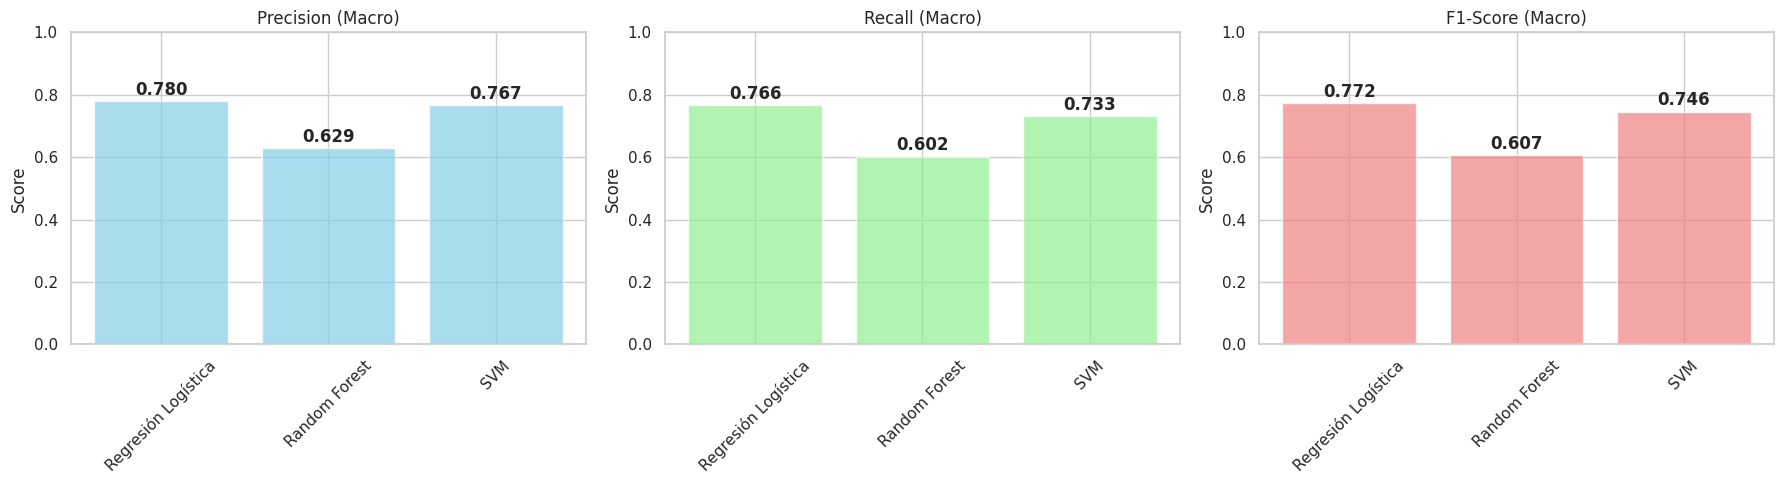


üèÜ MEJORES MODELOS POR M√âTRICA:
üéØ Mejor Precision: Regresi√≥n Log√≠stica (0.780)
üîç Mejor Recall:    Regresi√≥n Log√≠stica (0.766)
‚öñÔ∏è Mejor F1-Score:  Regresi√≥n Log√≠stica (0.772)


In [6]:
# Calcular m√©tricas de Precision, Recall y F1-Score
print("üéØ AN√ÅLISIS PRECISION-RECALL-F1")
print("=" * 45)

# Diccionario para almacenar resultados
resultados_prf = {}

for nombre_modelo, data in modelos_data.items():
    # Calcular m√©tricas para cada estrategia
    precision_macro = precision_score(y_test, data['pred'], average='macro')
    recall_macro = recall_score(y_test, data['pred'], average='macro')
    f1_macro = f1_score(y_test, data['pred'], average='macro')
    
    precision_weighted = precision_score(y_test, data['pred'], average='weighted')
    recall_weighted = recall_score(y_test, data['pred'], average='weighted')
    f1_weighted = f1_score(y_test, data['pred'], average='weighted')
    
    resultados_prf[nombre_modelo] = {
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted
    }
    
    print(f"\nü§ñ {nombre_modelo}:")
    print(f"   Precision (macro):    {precision_macro:.3f}")
    print(f"   Recall (macro):       {recall_macro:.3f}")
    print(f"   F1-Score (macro):     {f1_macro:.3f}")
    print(f"   F1-Score (weighted):  {f1_weighted:.3f}")

print("\n" + "=" * 45)

# An√°lisis detallado por clase
print("\nüìä AN√ÅLISIS DETALLADO POR CLASE:")
print("=" * 40)

for nombre_modelo, data in modelos_data.items():
    print(f"\nüîç {nombre_modelo.upper()}:")
    print(classification_report(y_test, data['pred'], 
                              target_names=classes, 
                              digits=3))

# Comparaci√≥n visual de m√©tricas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Preparar datos para visualizaci√≥n
modelos_nombres = list(resultados_prf.keys())
precision_scores = [resultados_prf[m]['precision_macro'] for m in modelos_nombres]
recall_scores = [resultados_prf[m]['recall_macro'] for m in modelos_nombres]
f1_scores = [resultados_prf[m]['f1_macro'] for m in modelos_nombres]

# Gr√°fico 1: Precision
axes[0].bar(modelos_nombres, precision_scores, color='skyblue', alpha=0.7)
axes[0].set_title('Precision (Macro)')
axes[0].set_ylabel('Score')
axes[0].set_ylim(0, 1)
for i, v in enumerate(precision_scores):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# Gr√°fico 2: Recall
axes[1].bar(modelos_nombres, recall_scores, color='lightgreen', alpha=0.7)
axes[1].set_title('Recall (Macro)')
axes[1].set_ylabel('Score')
axes[1].set_ylim(0, 1)
for i, v in enumerate(recall_scores):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

# Gr√°fico 3: F1-Score
axes[2].bar(modelos_nombres, f1_scores, color='lightcoral', alpha=0.7)
axes[2].set_title('F1-Score (Macro)')
axes[2].set_ylabel('Score')
axes[2].set_ylim(0, 1)
for i, v in enumerate(f1_scores):
    axes[2].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Identificar mejor modelo por m√©trica
mejor_precision = max(resultados_prf.items(), key=lambda x: x[1]['precision_macro'])
mejor_recall = max(resultados_prf.items(), key=lambda x: x[1]['recall_macro'])
mejor_f1 = max(resultados_prf.items(), key=lambda x: x[1]['f1_macro'])

print("\nüèÜ MEJORES MODELOS POR M√âTRICA:")
print(f"üéØ Mejor Precision: {mejor_precision[0]} ({mejor_precision[1]['precision_macro']:.3f})")
print(f"üîç Mejor Recall:    {mejor_recall[0]} ({mejor_recall[1]['recall_macro']:.3f})")
print(f"‚öñÔ∏è Mejor F1-Score:  {mejor_f1[0]} ({mejor_f1[1]['f1_macro']:.3f})")